## 빅데이터 활용 AI 설계
# DCGAN : MNIST

- GAN : Generative Adversarial Networks
- DCGAN : Deep Convolutional GAN
- Generator(생성자) / Discriminator(판별자)

<img src='https://skymind.ai/images/wiki/GANs.png' />
(출처 : https://skymind.ai/wiki/generative-adversarial-network-gan?fbclid=IwAR0V4kAn9b5GReI9F-OWSUtRPOUgKuWasqPJvuhgL-4ihot_OqYSNAeKd6Y)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### MNIST 로딩

In [2]:
from keras.datasets import mnist

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_train = X_train/255
X_test = X_test/255

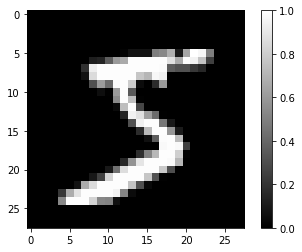

In [5]:
plt.imshow(X_train[0], cmap='gray')
plt.colorbar()

In [6]:
X_train = X_train[:,:,:,np.newaxis] # X_train.reshape(-1,28,28,1)
X_test = X_test[:,:,:,np.newaxis]

In [7]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((60000, 28, 28, 1), dtype('float64'), 1.0, 0.0)

In [8]:
X_test.shape

(10000, 28, 28, 1)

### 판별자 정의

In [9]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    Flatten, Reshape, LeakyReLU, BatchNormalization, Activation
from keras.optimizers import RMSprop

In [21]:
input = Input((28,28,1))
x = LeakyReLU(alpha=0.2)(input)

x = Conv2D(32, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, (5,5), strides=1, padding='same')(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(input, x)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         204928    
__________

<img src='https://www.researchgate.net/profile/Sepp_Hochreiter/publication/284579051/figure/fig1/AS:614057178578955@1523414048184/The-rectified-linear-unit-ReLU-the-leaky-ReLU-LReLU-a-01-the-shifted-ReLUs.png' />
(출처: https://www.researchgate.net/figure/The-rectified-linear-unit-ReLU-the-leaky-ReLU-LReLU-a-01-the-shifted-ReLUs_fig1_284579051)

In [22]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=2e-4, decay=6e-8), metrics=['acc'])
    # decay 값이 클수록 새롭게(처음으로) 변경되는 가중치를 많이 변화시킨다 (디폴트:0)

### 생성자 정의

In [23]:
input2 = Input((100,)) # 생성벡터는 100차원

x2 = Dense(7*7*128)(input2) # 랜덤 이미지가 입력됨

x2 = Reshape((7,7,128))(x2)

x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(128, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(64, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(32, (5,5), strides=1, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(1, (5,5), strides=1, padding='same')(x2)
x2 = Activation('sigmoid')(x2)

generator = Model(input2, x2)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_6 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 128)       512       
__________

### 적대망 정의
- 생성자로 생성한 이미지가 판별자에 의해 '실제이미지' 로 판별되도록 생성자의 가중치를 조절한다

In [24]:
discriminator.trainable = False # 모델들을 연결하여 새로운 모델을 만들 때만 적용된다

adversarial = Model(input2, discriminator(generator(input2)))
adversarial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_5 (Model)              (None, 28, 28, 1)         1301505   
_________________________________________________________________
model_4 (Model)              (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [25]:
adversarial.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])

### 훈련하기
- fake images: 0, real images: 1
- 1 step 에 10초 정도 소요됨
- C:\khh\프로그래밍\CNN\gan_images 폴더에 'fake_9.png' 형태로 저장함
- 생성자 모델을 'gan_mnist_generator_1000.h5' 로 저장함

In [26]:
from keras.preprocessing import image

batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(20): # 400
    indices = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_images/fake_'+str(step)+'.png')

C:\Anaconda3\envs\py36\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00001,  [0.69109976, 0.6796875, 1.7023078, 0.0]
Step: 00002,  [0.60281146, 0.5, 1.3037097, 0.0]
Step: 00003,  [0.4454613, 0.9921875, 2.6661963, 0.0]
Step: 00004,  [0.32630822, 0.9375, 0.9605808, 0.0]
Step: 00005,  [0.36893046, 1.0, 4.9451456, 0.0]
Step: 00006,  [0.33226445, 0.8515625, 2.2364511, 0.0]
Step: 00007,  [0.09914254, 0.9921875, 1.5909146, 0.0]
Step: 00008,  [0.071872056, 1.0, 1.1053394, 0.0]
Step: 00009,  [0.060655043, 1.0, 0.6886014, 0.546875]
Step: 00010,  [0.04756265, 0.9921875, 0.46726352, 0.96875]
Step: 00011,  [0.030303545, 1.0, 0.38212228, 0.984375]
Step: 00012,  [0.033970498, 0.9921875, 0.17008108, 1.0]
Step: 00013,  [0.030593866, 1.0, 0.25443292, 1.0]
Step: 00014,  [0.036132023, 1.0, 0.08582097, 1.0]
Step: 00015,  [0.040165752, 1.0, 0.13420378, 1.0]
Step: 00016,  [0.02516922, 1.0, 0.0875537, 1.0]
Step: 00017,  [0.023972522, 0.9921875, 0.0827646, 1.0]
Step: 00018,  [0.026030982, 0.9921875, 0.06526874, 1.0]
Step: 00019,  [0.02324659, 1.0, 0.13073212, 1.0]
Step: 0

In [27]:
generator.save('gan_mnist_generator_20.h5')

- 총 1000번 배치 실행 (이전 400번 + 신규 600번)

In [38]:
from keras.preprocessing import image

batch_size = 64

for step in range(400,1000): # 40000
    idx = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[idx]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, [%.3f, %.3f, %.3f, %.3f]' % (step+1,d_loss,d_acc,a_loss,a_acc))
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_images/fake_'+str(step)+'.png')

C:\Anaconda3\envs\py36\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00401, [0.600, 0.719, 0.907, 0.188]
Step: 00402, [0.611, 0.680, 0.673, 0.578]
Step: 00403, [0.604, 0.633, 1.126, 0.078]
Step: 00404, [0.623, 0.641, 0.531, 0.812]
Step: 00405, [0.664, 0.547, 1.288, 0.016]
Step: 00406, [0.709, 0.555, 0.490, 0.844]
Step: 00407, [0.706, 0.508, 1.568, 0.000]
Step: 00408, [0.698, 0.562, 0.541, 0.781]
Step: 00409, [0.710, 0.516, 1.197, 0.031]
Step: 00410, [0.608, 0.656, 0.728, 0.453]
Step: 00411, [0.572, 0.719, 0.889, 0.141]
Step: 00412, [0.610, 0.703, 0.822, 0.219]
Step: 00413, [0.606, 0.664, 1.181, 0.047]
Step: 00414, [0.633, 0.648, 0.626, 0.656]
Step: 00415, [0.655, 0.570, 1.514, 0.016]
Step: 00416, [0.708, 0.539, 0.560, 0.766]
Step: 00417, [0.655, 0.547, 1.259, 0.016]
Step: 00418, [0.698, 0.562, 0.544, 0.812]
Step: 00419, [0.636, 0.578, 1.112, 0.062]
Step: 00420, [0.619, 0.664, 0.724, 0.484]
Step: 00421, [0.587, 0.672, 0.978, 0.188]
Step: 00422, [0.589, 0.703, 0.775, 0.375]
Step: 00423, [0.627, 0.609, 0.988, 0.094]
Step: 00424, [0.632, 0.656, 0.781,

Step: 00597, [0.581, 0.688, 0.560, 0.719]
Step: 00598, [0.617, 0.594, 1.697, 0.016]
Step: 00599, [0.676, 0.578, 0.450, 0.844]
Step: 00600, [0.635, 0.578, 1.215, 0.094]
Step: 00601, [0.608, 0.641, 0.909, 0.266]
Step: 00602, [0.555, 0.703, 1.139, 0.047]
Step: 00603, [0.565, 0.680, 0.823, 0.312]
Step: 00604, [0.583, 0.727, 1.379, 0.047]
Step: 00605, [0.609, 0.641, 0.637, 0.531]
Step: 00606, [0.629, 0.594, 1.431, 0.047]
Step: 00607, [0.602, 0.641, 0.537, 0.812]
Step: 00608, [0.591, 0.656, 1.318, 0.047]
Step: 00609, [0.604, 0.656, 0.612, 0.719]
Step: 00610, [0.591, 0.617, 1.462, 0.016]
Step: 00611, [0.653, 0.594, 0.601, 0.734]
Step: 00612, [0.541, 0.695, 1.088, 0.156]
Step: 00613, [0.561, 0.734, 0.605, 0.672]
Step: 00614, [0.547, 0.727, 1.015, 0.203]
Step: 00615, [0.569, 0.742, 0.833, 0.375]
Step: 00616, [0.560, 0.750, 1.148, 0.078]
Step: 00617, [0.527, 0.727, 0.742, 0.469]
Step: 00618, [0.573, 0.695, 1.315, 0.062]
Step: 00619, [0.559, 0.664, 0.548, 0.719]
Step: 00620, [0.665, 0.562, 1.839,

Step: 00793, [0.600, 0.664, 0.796, 0.391]
Step: 00794, [0.547, 0.727, 1.374, 0.047]
Step: 00795, [0.610, 0.625, 0.577, 0.719]
Step: 00796, [0.688, 0.594, 1.511, 0.047]
Step: 00797, [0.718, 0.555, 0.495, 0.828]
Step: 00798, [0.674, 0.562, 1.445, 0.016]
Step: 00799, [0.583, 0.680, 0.705, 0.516]
Step: 00800, [0.609, 0.625, 1.259, 0.031]
Step: 00801, [0.615, 0.656, 0.707, 0.594]
Step: 00802, [0.700, 0.555, 1.177, 0.172]
Step: 00803, [0.596, 0.719, 0.689, 0.484]
Step: 00804, [0.611, 0.656, 1.259, 0.094]
Step: 00805, [0.607, 0.656, 0.652, 0.578]
Step: 00806, [0.622, 0.695, 1.423, 0.031]
Step: 00807, [0.671, 0.617, 0.535, 0.734]
Step: 00808, [0.667, 0.570, 1.305, 0.016]
Step: 00809, [0.617, 0.656, 0.631, 0.656]
Step: 00810, [0.662, 0.602, 1.076, 0.156]
Step: 00811, [0.596, 0.703, 0.730, 0.453]
Step: 00812, [0.590, 0.719, 1.033, 0.141]
Step: 00813, [0.567, 0.758, 0.808, 0.391]
Step: 00814, [0.615, 0.688, 0.794, 0.406]
Step: 00815, [0.552, 0.766, 0.948, 0.188]
Step: 00816, [0.569, 0.789, 0.789,

Step: 00989, [0.605, 0.641, 0.642, 0.672]
Step: 00990, [0.585, 0.648, 1.292, 0.078]
Step: 00991, [0.607, 0.664, 0.738, 0.406]
Step: 00992, [0.623, 0.656, 1.091, 0.156]
Step: 00993, [0.536, 0.773, 0.912, 0.266]
Step: 00994, [0.595, 0.680, 1.148, 0.109]
Step: 00995, [0.614, 0.672, 0.686, 0.672]
Step: 00996, [0.646, 0.602, 1.600, 0.016]
Step: 00997, [0.707, 0.570, 0.710, 0.438]
Step: 00998, [0.630, 0.609, 1.274, 0.047]
Step: 00999, [0.638, 0.609, 0.569, 0.703]
Step: 01000, [0.665, 0.555, 1.167, 0.094]


In [40]:
generator.save('gan_mnist_generator_1000.h5')

In [43]:
np.save('gan_mnist_log.npy', logs)

### 결과 분석

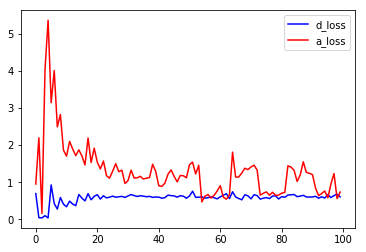

In [47]:
plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.legend()

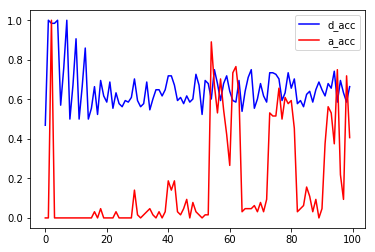

In [46]:
plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()

- 결과 비교
<img src='https://d33wubrfki0l68.cloudfront.net/1439d140302850f4652f4def43d264b7afa39e65/81f84/assets/images/gan-intro/mnistkeras_19_0.png' />
(출처: https://www.wouterbulten.nl/blog/tech/getting-started-with-generative-adversarial-networks/)

### 숫자 이미지 생성

In [29]:
from keras.models import load_model

#generator = load_model('gan_mnist_generator_1000.h5')

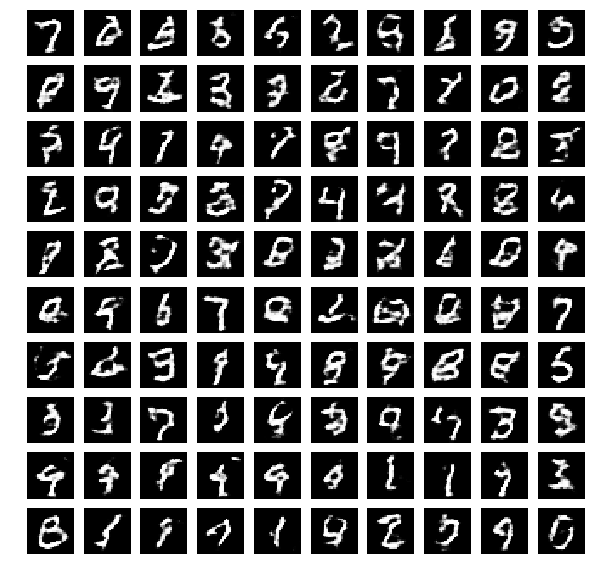

In [41]:
vectors = np.random.uniform(-1, 1, size=[100,100])
images = generator.predict(vectors)

plt.figure(figsize=[10,10])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')

### Fashion MNIST

In [30]:
from keras.datasets.fashion_mnist import load_data

In [31]:
fmnist = load_data()

4423680/4422102 [==============================] - 6s 1us/step


In [33]:
fmnist[1][0].shape

(10000, 28, 28)